# Neurons and Layers

<figure>
   <img src="./images/C2_W1_NeuronsAndLayers.png"  style="width:540px;height:300px;" >
</figure>


## Packages

**Tensorflow and Keras**  

Tensorflow is a machine learning package developed by Google. In 2019, Google integrated Keras into Tensorflow and released Tensorflow 2.0. Keras is a framework developed independently by François Chollet that creates a simple, layer-centric interface to Tensorflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.activations import sigmoid

from lab_utils_common import dlc
from lab_neurons_utils import plt_prob_1d, sigmoidnp, plt_linear, plt_logistic
plt.style.use('./deeplearning.mplstyle')
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
# More verbose logging is useful when filing bug reports or doing more in-depth debugging
tf.autograph.set_verbosity(0)

## Neuron without activation - Regression/Linear Model

### DataSet

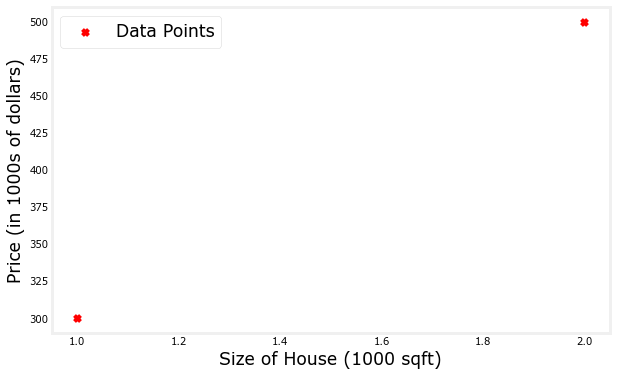

In [4]:
X_train = np.array([[1.0], [2.0]], dtype=np.float32)           # (size in 1000 square feet)
Y_train = np.array([[300.0], [500.0]], dtype=np.float32)       # (price in 1000s of dollars)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 6)
ax.scatter(X_train, Y_train, marker='x', c='r', label="Data Points")
ax.legend( fontsize='xx-large')
ax.set_ylabel('Price (in 1000s of dollars)', fontsize='xx-large')
ax.set_xlabel('Size of House (1000 sqft)', fontsize='xx-large')
plt.show()

### Regression/Linear Model 
The function implemented by a neuron with no activation is the linear regression function:
$$ f_{\mathbf{w},b}(x^{(i)}) = \mathbf{w}\cdot x^{(i)} + b \tag{1}$$



We can define a layer with one neuron or unit and compare it to the familiar linear regression function.

In [9]:
linear_layer = tf.keras.layers.Dense(units=1, activation = 'linear', use_bias=True)

The function `Dense` implements the operation: 

`output = activation(dot(input, kernel) + bias)` 

where 

* activation is the **element-wise activation function** passed as the activation argument
* kernel is a weights matrix created by the layer
* bias is a bias vector created by the layer (only applicable if use_bias is True)

If the input to the layer has a rank greater than 2, then `Dense` computes the dot product between the inputs and the kernel along the last axis of the inputs and axis 0 of the kernel (using `tf.tensordot`). The rank of a tensor is not the same as the rank of a matrix. The rank of a tensor is the **number of indices required to uniquely select each element of the tensor**. Rank is also known as "order", "degree", or "ndims".

In [6]:
# Two batches, each with 2 rows and 3 columns
t = tf.constant([[[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]]])
t

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[1, 1, 1],
        [2, 2, 2]],

       [[3, 3, 3],
        [4, 4, 4]]], dtype=int32)>

In [7]:
tf.rank(t)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In this example, the input `t` has dimensions `(batch_size = 2, d0 = 2, d1 = 3)`, then we create a kernel with shape `(d1 = 3, units)`, and the kernel operates along the last axis 2 (among axis 0, 1, and 2) of the input, on every sub-tensor of shape `(1, 1, d1 = 3)` (there are `batch_size * d0` such sub-tensors). The output in this case will have shape `(batch_size, d0, units)`. The function returns the following instance:

In [11]:
type(linear_layer)

tensorflow.python.keras.layers.core.Dense

Examining the weights:

In [12]:
linear_layer.get_weights()

[]

There are no weights as the weights are not yet instantiated. Let's try the model on one example (or row) in `X_train`. This will trigger the instantiation of the weights. Note, the input to the layer must be 2-dimensional, so we'll reshape it.

In [23]:
print('From 1D', X_train[0], 'to', '2D', X_train[0].reshape(1,1))

From 1D [1.] to 2D [[1.]]


In [24]:
a1 = linear_layer(X_train[0].reshape(1,1))
# First vector of activation values
print(a1)

tf.Tensor([[0.3]], shape=(1, 1), dtype=float32)


The result is a tensor (another name for an array) with a shape of (1,1) or one entry. A tensor is a data type created by the TensorFlow team that store and carry out efficient array or matrix computations. Now let's look at the weights and bias. These weights are randomly initialized to small numbers and the bias defaults to being initialized to zero.

In [25]:
w, b= linear_layer.get_weights()
print(f"w = {w}, b={b}")

w = [[0.3]], b=[0.]


A linear regression model (1) with a single input feature will have a single weight and bias. This matches the dimensions of our `linear_layer` above.   

The weights are initialized to random values so let's set them to some known constants.

In [26]:
# These are the slope and intercept needed to map an inout of X = 1 to an output of Y = 300 via the linear equation Y = wX + b
set_w = np.array([[200]])
set_b = np.array([100])

# The method set_weights takes a list of numpy arrays
linear_layer.set_weights([set_w, set_b])
print(linear_layer.get_weights())

[array([[200.]], dtype=float32), array([100.], dtype=float32)]


Let's compare equation (1) to the layer output.

In [28]:
a1 = linear_layer(X_train[0].reshape(1,1))
print(a1, '\n')
# Using manual calculation with known constants
alin = np.dot(set_w,X_train[0].reshape(1,1)) + set_b
print(alin)

tf.Tensor([[300.]], shape=(1, 1), dtype=float32) 

[[300.]]


They produce the same values. Now, we can use our linear layer to make predictions on our training data.

In [31]:
prediction_tf = linear_layer(X_train)
# Using manual calculation with known constants
prediction_np = np.dot(X_train, set_w) + set_b

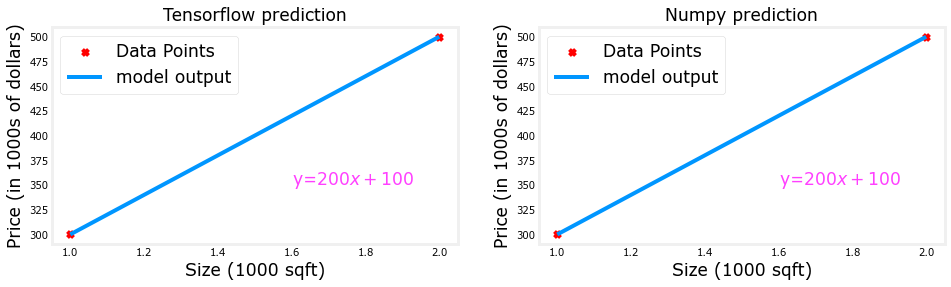

In [30]:
plt_linear(X_train, Y_train, prediction_tf, prediction_np)

## Neuron with Sigmoid activation
The function implemented by a neuron/unit with a sigmoid activation is the same as the logistic regression:

$$ f_{\mathbf{w},b}(x^{(i)}) = g(\mathbf{w}x^{(i)} + b) \tag{2}$$
where 

* $g(x) = \text{sigmoid}(x) = \frac{1}{1+e^{-x}}$

Let's set $w$ and $b$ to some known values and check the model.


### DataSet

In [50]:
X_train = np.array([0., 1, 2, 3, 4, 5], dtype=np.float32).reshape(-1,1)  # 2-D Matrix
Y_train = np.array([0,  0, 0, 1, 1, 1], dtype=np.float32).reshape(-1,1)  # 2-D Matrix

In [34]:
X_train.shape, Y_train.shape

((6, 1), (6, 1))

In [36]:
pos = Y_train == 1
neg = Y_train == 0
# Indices of positive examples
X_train[pos]

array([3., 4., 5.], dtype=float32)

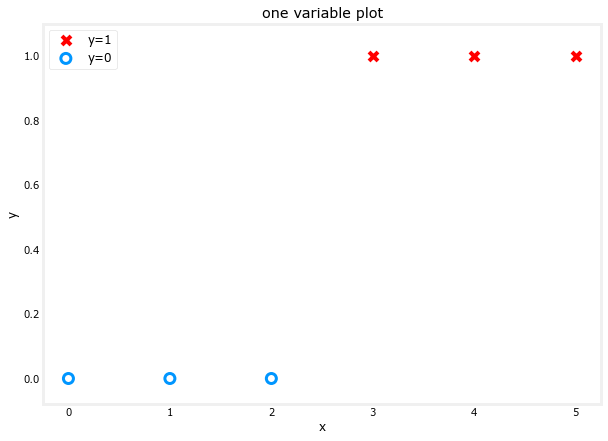

In [38]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
fig.set_size_inches(10,7)
ax.scatter(X_train[pos], Y_train[pos], marker='x', s=80, c = 'red', label="y=1")
ax.scatter(X_train[neg], Y_train[neg], marker='o', s=100, label="y=0", facecolors='none', 
              edgecolors=dlc["dlblue"],lw=3)

ax.set_ylim(-0.08,1.1)
ax.set_ylabel('y', fontsize=12)
ax.set_xlabel('x', fontsize=12)
ax.set_title('one variable plot')
ax.legend(fontsize=12)
plt.show()

### Logistic Neuron
We can implement a 'logistic neuron' by adding a sigmoid activation. The function of the neuron is then described by (2) above.   
This section will create a Tensorflow Model that contains our logistic layer to demonstrate an alternate method of creating models. Tensorflow is most often used to create multi-layer models. The [Sequential](https://keras.io/guides/sequential_model/) model is a convenient means of constructing these models.

In [43]:
model = Sequential(
    [tf.keras.layers.Dense(units=1, input_dim=1,  activation = 'sigmoid', name='L1')] # A logistic layer called 'L1'
)

A "Sequential" model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. The `summary()` method shows the layers and number of parameters in the model. There is only one layer in this model and that layer has only one unit. The unit has two parameters, $w$ and $b$.

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1 (Dense)                   (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Retrieves a layer from sequential model based on either its name (unique) or index
logistic_layer = model.get_layer('L1')
# Retrieve the weights and intercepts
w,b = logistic_layer.get_weights()
print(w,b)
print(w.shape,b.shape)

[[-1.45]] [0.]
(1, 1) (1,)


Let's set the weight and bias to some known values.

In [46]:
# Set the parameters manually
set_w = np.array([[2]])
set_b = np.array([-4.5])
# The method set_weights takes a list of numpy arrays
logistic_layer.set_weights([set_w, set_b])
print(logistic_layer.get_weights())

[array([[2.]], dtype=float32), array([-4.5], dtype=float32)]


Let's compare equation (2) to the layer output.

In [51]:
# Training data
X_train, Y_train

(array([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]], dtype=float32))

In [53]:
# Example the first training example
a1 = model.predict(X_train[0].reshape(1,1))
print(a1)
# Manually transforming linear predictor using sigmoid function
alog = sigmoidnp(np.dot(set_w,X_train[0].reshape(1,1)) + set_b)
print(alog)

[[0.01]]
[[0.01]]


They produce the same values, again. Now, we can use our logistic layer and NumPy model to make predictions on our training data.

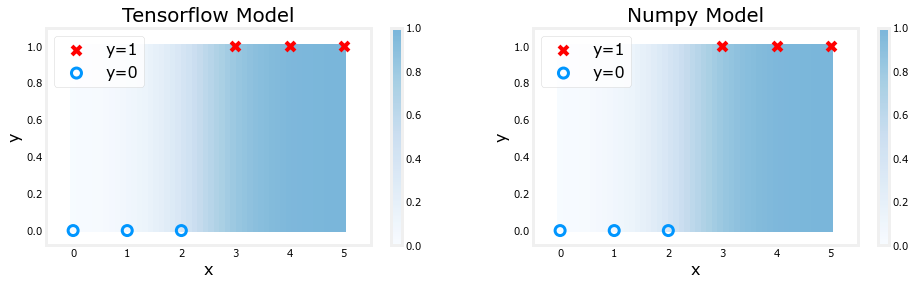

In [54]:
# For all training examples or rows of the X train matrix
plt_logistic(X_train, Y_train, model, set_w, set_b, pos, neg)

The shading above reflects the output of the sigmoid which varies from 0 to 1.